In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [16]:
file_path = r"F:\Xai_traderx\data\processed\axis_processed.csv"
df = pd.read_csv(file_path)

In [17]:
df.head()

,Date,Close,High,Low,Open,Volume,Close_Return_1D,Close_Return_3D,Return,High_Low_Spread,...,bb_upper,bb_lower,bb_width,Bollinger_%B,bear_score,bull_strength,bear_strength,Momentum,Volatility,next_close
0,2020-07-15,424.799133,442.521933,420.916058,422.160635,43250557,0.021427,-0.029459,0.021427,0.050861,...,454.303081,398.685371,0.130407,0.469522,0.0,0.0,0.0,-17.424042,14.353156,432.117218
1,2020-07-16,432.117218,434.257885,416.634689,430.076123,30183647,0.017227,-0.013748,0.017227,0.040783,...,453.637754,402.198291,0.120209,0.581634,0.0,0.0,0.0,-19.664337,14.293742,431.221161
2,2020-07-17,431.221161,437.991649,422.758035,432.117250,33464985,-0.002074,0.036869,-0.002074,0.035327,...,453.762583,403.671502,0.116839,0.549991,0.0,0.0,0.0,-6.471771,12.168083,432.117218
3,2020-07-20,432.117218,440.879030,427.437595,435.801179,30400586,0.002078,0.017227,0.002078,0.031106,...,453.998923,403.818494,0.116996,0.563939,0.0,0.0,0.0,-6.023743,9.547082,444.264313
4,2020-07-21,444.264313,449.043477,436.597705,438.091197,43147019,0.028111,0.028111,0.028111,0.028014,...,454.422846,403.648464,0.118345,0.799928,0.0,0.0,0.0,28.376343,9.983551,476.872223


In [18]:
selected_features = [
    # Price Action
    'Close', 'High', 'Low'
]

df_selected = df[selected_features]

In [19]:
# Separate features and target
features = df_selected
target = df[['next_close']]

In [20]:
# Scale features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

# Scale target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)

In [21]:
lookback = 30
def create_sequence(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:(i + lookback)])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)


X_train_seq, y_train_seq = create_sequence(X_train, y_train, lookback)
X_test_seq, y_test_seq = create_sequence(X_test, y_test, lookback)

In [22]:
# Print shapes of training and testing sequences
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)


Shape of X_train_seq: (919, 30, 3)
Shape of y_train_seq: (919, 1)
Shape of X_test_seq: (208, 30, 3)
Shape of y_test_seq: (208, 1)


In [23]:
model = Sequential([
    Input(shape=(lookback, X_train_seq.shape[2])),
    GRU(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])


print("Model Builded")
# Compile
optimizer = Nadam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

Model Builded


In [24]:
callbacks = [
    EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True),
    ModelCheckpoint('axisgru30.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=25, min_lr=1e-6)
]

# training
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=500,
    batch_size=16,
    callbacks=callbacks,
    shuffle=False,  
    verbose=1
)
print('training Completed...')

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0453 - mae: 0.2766 - val_loss: 0.0249 - val_mae: 0.2169 - learning_rate: 1.0000e-04
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mae: 0.0561 - val_loss: 0.0016 - val_mae: 0.0462 - learning_rate: 1.0000e-04
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mae: 0.0748 - val_loss: 0.0011 - val_mae: 0.0370 - learning_rate: 1.0000e-04
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - mae: 0.0720 - val_loss: 0.0011 - val_mae: 0.0358 - learning_rate: 1.0000e-04
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mae: 0.0658 - val_loss: 8.7482e-04 - val_mae: 0.0317 - learning_rate: 1.0000e-04
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mae: 0.0582 - val_loss: 8.0424e-04 - val_mae: 0.0298 - learning_rate: 1.0000e-04
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mae: 0.0546 - val_loss: 7.9745e-04 - val_mae: 0.029

In [25]:
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3223e-04 - mae: 0.0197  
Test Loss: 0.0003433835518080741
Test MAE: 0.01970985345542431


In [26]:
y_pred_scaled = model.predict(X_test_seq)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [27]:
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_test_seq = y_test_seq.reshape(-1, 1)

# Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
percentage_error = (mae / np.mean(y_true)) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Percentage Error: {percentage_error:.2f}%")

MAE: 18.0660
RMSE: 24.0205
R2 Score: 0.9242
Percentage Error: 1.60%


In [28]:
result_df = pd.DataFrame({
    'Actual': y_true.flatten(),
    'Predicted': y_pred.flatten()
})

result_df

,Actual,Predicted
0,1260.926880,1280.141724
1,1252.433472,1259.036499
2,1279.012939,1247.788330
3,1279.912231,1239.285522
4,1286.057495,1258.491455
...,...,...
203,1166.300049,1202.094360
204,1192.800049,1196.789429
205,1187.300049,1157.781616
206,1185.000000,1173.070312


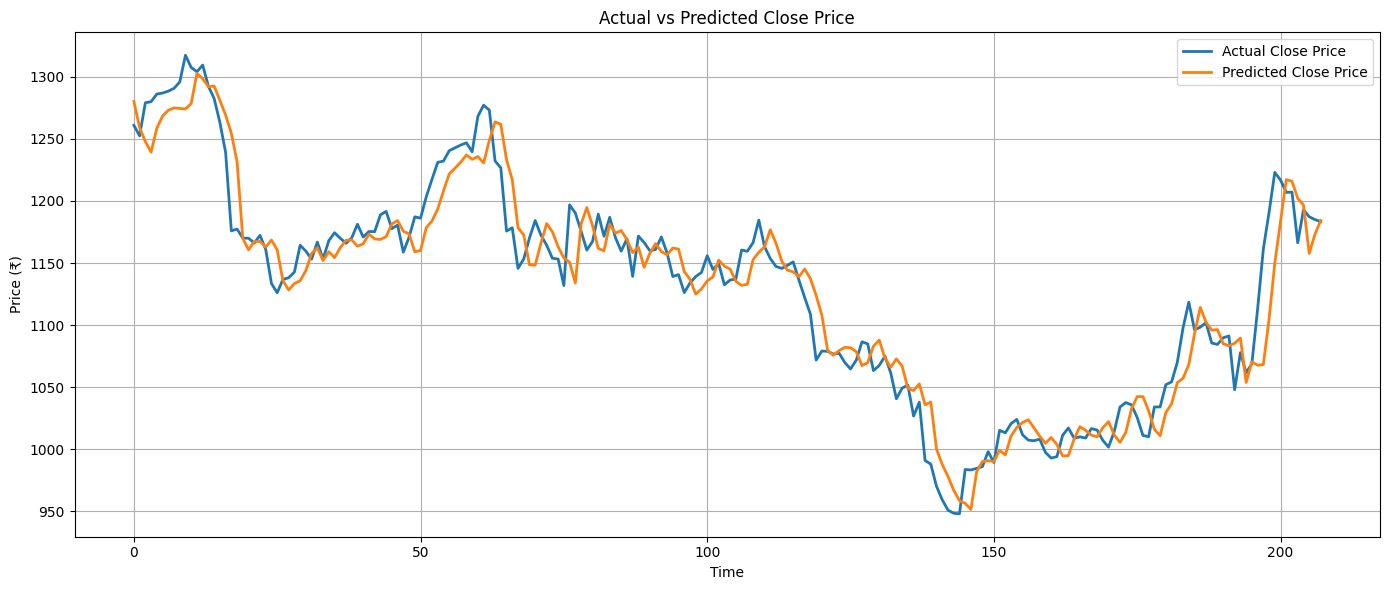

In [29]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual Close Price', linewidth=2)
plt.plot(y_pred, label='Predicted Close Price', linewidth=2)
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

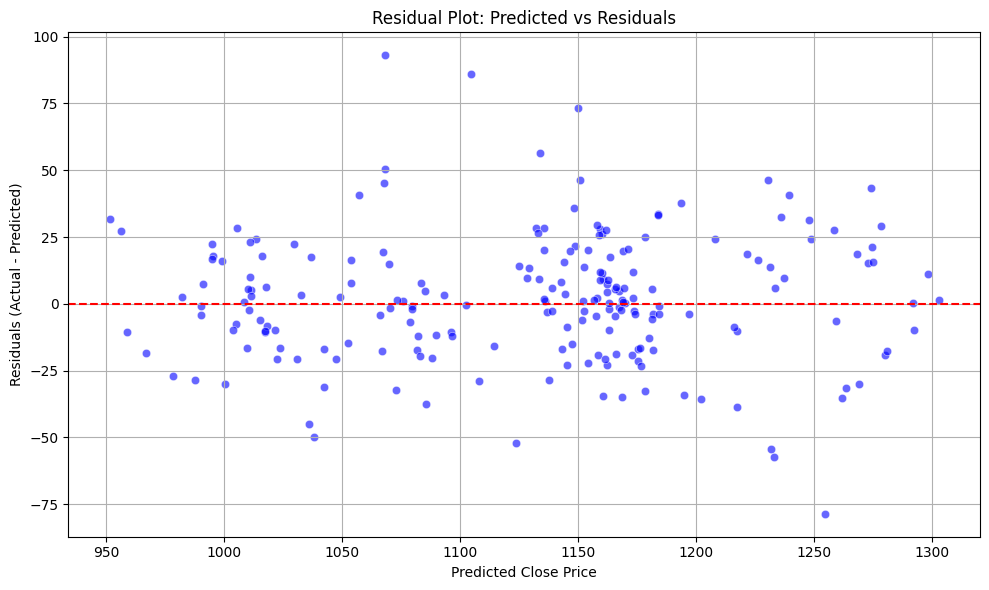

In [30]:
# Calculate residuals
residuals = y_true.flatten() - y_pred.flatten()

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred.flatten(), y=residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot: Predicted vs Residuals')
plt.xlabel('Predicted Close Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
df['Date'] = pd.to_datetime(df['Date']) 
df.set_index('Date', inplace=True)  

# Get the dates corresponding to the predictions
valid_dates = df.index[-len(y_true):] 

result_df = pd.DataFrame({
    'Date': valid_dates,
    'Open': df['Open'].loc[valid_dates].values,  # Adding the Open price
    'Actual_Close': y_true.flatten(),
    'Predicted_Close': y_pred.flatten()
})

# Calculate Directional Accuracy
result_df['Actual_Direction'] = np.sign(result_df['Actual_Close'] - df['Close'].shift(1).loc[valid_dates].values)
result_df['Predicted_Direction'] = np.sign(result_df['Predicted_Close'] - df['Close'].shift(1).loc[valid_dates].values)
result_df['Correct_Direction'] = result_df['Actual_Direction'] == result_df['Predicted_Direction']




print(result_df.head())

        Date         Open  Actual_Close  Predicted_Close  Actual_Direction  \
0 2024-06-28  1282.110502   1260.926880      1280.141724              -1.0   
1 2024-07-01  1272.018295   1252.433472      1259.036499              -1.0   
2 2024-07-02  1264.024502   1279.012939      1247.788330               1.0   
3 2024-07-03  1259.028362   1279.912231      1239.285522               1.0   
4 2024-07-04  1287.006732   1286.057495      1258.491455               1.0   

   Predicted_Direction  Correct_Direction  
0                 -1.0               True  
1                 -1.0               True  
2                 -1.0              False  
3                 -1.0              False  
4                 -1.0              False  


In [ ]:
prev_close_scaled = X_test_seq[:, -1, 0].reshape(-1, 1)
prev_close = scaler_y.inverse_transform(prev_close_scaled)

# Calculate directional accuracy
true_direction = np.sign(y_true.flatten() - prev_close.flatten())
pred_direction = np.sign(y_pred.flatten() - prev_close.flatten())

directional_accuracy = np.mean(true_direction == pred_direction) * 100

print(f"Directional Accuracy: {directional_accuracy:.2f}%")

Directional Accuracy: 52.40%
